# Clustering Analysis

As we approach to the last step of exploring this basketball player dataset, I am going to use unsupervised learning methods to cluster the players into categories that can better summarizes the unique characters of its members. The main idea is to get over the “curse of dimensionality” i.e, boil down a large dataset by removing extra umimportant attributes and extract the essence of the data. I will use Principal Component Analysis (PCA) to find the most crucial sttributes of the dataset and use K-means Clustering to optimaly categorize the data. 

Lets first start by loading the python libraries.

In [1669]:
                                                                            import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import cluster as skc
import sklearn as skl
import sklearn.preprocessing
%matplotlib inline
import csv

I will continue to use the cleansed version of player season data, and I will create an all numerical version of it, for future computing purpose. 

In [1670]:
with open('data/Seasons_Stats_cleansed.csv') as csvfile:
    reader1 = csv.reader(csvfile)
data = pd.read_csv('data/Seasons_Stats_cleansed.csv',sep='\t')

str_list = [] # empty list to contain columns with strings
for colname, colvalue in data.iteritems():
    if type(colvalue[1]) == str:
        str_list.append(colname)
#Get to the numeric columns by inversion
data_num_list = data.columns.difference(str_list)
data_num = data[data_num_list]

Both the original dataset and all numerical dataset will be divided into four subsets according to time period.

In [1671]:
pre90s_all = data[~(data['Year']>1989)]
_90s_all = data[~(data['Year']<1990) & ~(data['Year']>1999)]
_00s_all = data[~(data['Year']<2000) & ~(data['Year']>2009)]
_10s_all = data[~(data['Year']<2010)]

In [1672]:
pre90s = data_num[~(data_num['Year']>1989)]
_90s = data_num[~(data_num['Year']<1990) & ~(data_num['Year']>1999)]
_00s = data_num[~(data_num['Year']<2000) & ~(data_num['Year']>2009)]
_10s = data_num[~(data_num['Year']<2010)]

Since we want to observe the changing behavior of basketball throughout time, I will choose the two subsets have the largest time gap in between, which is pre90(players data before 1990) and _10s(players since 2010).

Now, that we have selected the data we need to standardize the data. We will standardize the data by defining a function for standardization.

In [1673]:
def standardization_f(x):
    x_bar = np.mean(x)
    s = np.std(x)
    x_z = (x - x_bar) / s
    return(x_z)
#print(pre90s_num.corr())
pre90s_z = pre90s.apply(standardization_f, broadcast = True)

_10s_z = _10s.apply(standardization_f, broadcast = True)
_10s_z.head()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: The broadcast argument is deprecated and will be removed in a future version. You can specify result_type='broadcast' to broadcast the result to the original dimensions
  import sys
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: The broadcast argument is deprecated and will be removed in a future version. You can specify result_type='broadcast' to broadcast the result to the original dimensions
  if __name__ == '__main__':


,2P,2P%,2PA,3P,3P%,3PA,3PAr,AST,AST%,Age,...,USG%,Unnamed: 0,Unnamed: 0.1,VORP,WS,WS/48,Year,eFG%,height,weight
9290,-0.938818,0.078233,-1.014302,0.689031,1.028820,0.370043,0.809270,-0.406370,-0.472693,-0.643896,...,-1.042738,-1.739685,-1.741503,0.289801,-0.047769,-0.064845,-1.555639,1.158798,-0.490777,-0.358989
9291,1.624303,0.257408,1.650508,-1.111994,0.245125,-1.184604,-1.193365,-0.535781,-0.408557,-0.643896,...,0.767080,-1.738443,-1.740056,0.739534,0.905728,0.914500,-1.555639,-0.060989,1.139415,1.420452
9292,-0.419429,-1.337246,-0.029195,-1.093498,-0.700491,-1.072605,-1.008655,-0.880822,-0.921647,1.050877,...,-1.042738,-1.737201,-1.738609,-1.546497,-1.569687,-1.598537,-1.555639,-2.012649,0.813376,1.258685
9293,-0.116779,1.296620,-0.441110,0.796900,0.568966,0.799073,0.731498,-0.189544,-0.152012,1.777208,...,0.218034,-1.735958,-1.737886,0.787555,0.720250,0.729718,-1.555639,1.036819,0.269979,-0.035455
9294,0.551099,0.651592,0.384115,-1.177683,-1.782119,-1.182437,-1.164200,-0.075602,-0.077186,0.324546,...,0.096024,-1.734716,-1.737162,0.422136,0.130567,0.082981,-1.555639,0.203298,-0.816816,-0.278106


As you see, all the numerical attributes have been normalized to the range from 0 to 1 despite the nature of its original scope, so that bias will not be triggered due to various magnitude in different numeric attribute. 

### Principal Component Analysis
Principal component analysis is a unsupervised machine learning algorithm which reduces the dimensionality of the data by eigenvalue and eigenvector decomposition of the covariance matrix.

Lets first start by computing the co-variance matrix of the standardized data.

In [1674]:
pre90s_RR = pre90s_z.cov()
_10s_RR = _10s_z.cov()

In [1675]:
_10s_RR.head(5)

,2P,2P%,2PA,3P,3P%,3PA,3PAr,AST,AST%,Age,...,USG%,Unnamed: 0,Unnamed: 0.1,VORP,WS,WS/48,Year,eFG%,height,weight
2P,1.000364,0.391232,0.964768,-0.484137,-0.300482,-0.488516,-0.686918,0.024148,0.103149,-0.136256,...,0.686593,-0.032550,-0.032863,0.281777,0.414180,0.414491,-0.037616,0.109361,0.260264,0.345024
2P%,0.391232,1.000364,0.155843,-0.334705,-0.292007,-0.361938,-0.379820,-0.221562,-0.206441,-0.016515,...,-0.069377,0.061918,0.060964,0.429139,0.580604,0.580018,0.067002,0.766517,0.347675,0.346460
2PA,0.964768,0.155843,1.000364,-0.431735,-0.241877,-0.427143,-0.645174,0.093372,0.175256,-0.148581,...,0.762925,-0.055889,-0.055902,0.171885,0.264925,0.265437,-0.062416,-0.111486,0.178441,0.266648
3P,-0.484137,-0.334705,-0.431735,1.000364,0.659917,0.982974,0.910757,0.213773,0.212651,0.090963,...,0.194881,0.151137,0.151123,0.076609,-0.066089,-0.066514,0.154937,0.092019,-0.405066,-0.463663
3P%,-0.300482,-0.292007,-0.241877,0.659917,1.000364,0.643682,0.638446,0.300690,0.295674,0.058674,...,0.167101,0.089403,0.089490,0.063544,-0.078379,-0.078905,0.090325,-0.006033,-0.394549,-0.461211


Then, calculate the eigenvalues and eigenvectors of covariance matrix.

In [1676]:
pre90s_eigen_RR = np.linalg.eig(pre90s_RR)
_10s_eigen_RR = np.linalg.eig(_10s_RR)
print(_10s_eigen_RR[0])
print(_10s_eigen_RR[1][1:3])

[ 1.40211478e+01  9.78263317e+00  5.02994181e+00  3.61462370e+00
  3.09415763e+00  2.28836294e+00  1.88183377e+00  1.38980148e+00
  1.36679667e+00  1.12855986e+00  9.74193937e-01  7.71271377e-01
  6.76822810e-01  6.36530812e-01  5.82087974e-01  4.87586863e-01
  4.18781050e-01  3.82983561e-01  2.98047111e-01  2.35096250e-01
  2.00589611e-01  1.78328955e-01  1.43116732e-01  1.06366972e-01
  8.01915990e-02  6.81858878e-02  5.64669892e-02  3.43666258e-02
  2.22385508e-02  1.45302350e-02  1.31364750e-02  1.04527820e-02
  6.95773530e-03  5.90688071e-03  3.95733899e-03  3.24429392e-03
  2.31046740e-03  1.95080919e-03  1.62149501e-03  1.37915377e-03
  8.23987249e-04  2.59881701e-04  2.11043271e-04  1.50008359e-04
  1.34550596e-04  5.54569702e-05  1.71224464e-16  5.85901865e-17
 -1.68737164e-16 -2.52766875e-16]
[[-1.73422619e-01 -6.39513696e-02 -1.61205211e-01 -4.27486784e-04
   1.74441629e-02 -1.69537190e-01 -1.82358257e-01 -2.31848599e-01
   3.91608897e-02  1.51213249e-01 -4.70223330e-02 -1.9

In this output, the first row is the eigenvalues for the 50 variables we have used in this dataset. The subsequent rows are the eigenvectors in 50 directions (first two directions in the above sample). The number of principal components is equal to the number of variables we have in the dataset. But, not all of the principal components are informative. To see, how many of them are informative or relevant, we calculate the proportion of variance explained by each PC. Now, lets see what proportion of variance is explained by the Principal components in this analysis.

In [1677]:
# Proportion of variance explained by each PC.
print(pre90s_eigen_RR[0] / sum(pre90s_eigen_RR[0]))

[ 2.37781105e-01+0.00000000e+00j  2.22531710e-01+0.00000000e+00j
  1.02170032e-01+0.00000000e+00j  8.09031000e-02+0.00000000e+00j
  5.51989764e-02+0.00000000e+00j  5.27048451e-02+0.00000000e+00j
  3.94043677e-02+0.00000000e+00j  3.29194022e-02+0.00000000e+00j
  2.87626438e-02+0.00000000e+00j  2.51859318e-02+0.00000000e+00j
  1.97177742e-02+0.00000000e+00j  1.48744281e-02+0.00000000e+00j
  1.34752374e-02+0.00000000e+00j  1.22839458e-02+0.00000000e+00j
  1.04580151e-02+0.00000000e+00j  9.84844289e-03+0.00000000e+00j
  8.86222867e-03+0.00000000e+00j  7.68283202e-03+0.00000000e+00j
  5.92946358e-03+0.00000000e+00j  4.71647244e-03+0.00000000e+00j
  3.42916385e-03+0.00000000e+00j  2.72581981e-03+0.00000000e+00j
  1.85044581e-03+0.00000000e+00j  1.44003883e-03+0.00000000e+00j
  1.17862183e-03+0.00000000e+00j  1.01446383e-03+0.00000000e+00j
  8.60731579e-04+0.00000000e+00j  5.27205721e-04+0.00000000e+00j
  4.02974968e-04+0.00000000e+00j  3.41331470e-04+0.00000000e+00j
  1.75916290e-04+0.000000

For the pre90s players, the first two principal components explains 23.8% and 22.3% of the variance.

In [1678]:
print(_10s_eigen_RR[0] / sum(_10s_eigen_RR[0]))

[ 2.80320946e-01  1.95581491e-01  1.00562241e-01  7.22661762e-02
  6.18606414e-02  4.57506101e-02  3.76229843e-02  2.77859183e-02
  2.73259895e-02  2.25629866e-02  1.94767911e-02  1.54198162e-02
  1.35315321e-02  1.27259852e-02  1.16375246e-02  9.74818988e-03
  8.37257420e-03  7.65688486e-03  5.95877381e-03  4.70021459e-03
  4.01033287e-03  3.56528169e-03  2.86129341e-03  2.12656558e-03
  1.60324856e-03  1.36322168e-03  1.12892897e-03  6.87082487e-04
  4.44609223e-04  2.90498986e-04  2.62633928e-04  2.08979591e-04
  1.39104086e-04  1.18094639e-04  7.91179887e-05  6.48622750e-05
  4.61925385e-05  3.90019909e-05  3.24181032e-05  2.75730416e-05
  1.64737502e-05  5.19574329e-06  4.21933001e-06  2.99907581e-06
  2.69003302e-06  1.10873593e-06  3.42324356e-18  1.17137746e-18
 -3.37351565e-18 -5.05349853e-18]


For the post 2010 players, the first two principal components explains 28% and 19.5% of the variance.

Since we want sufficient number of principal components to explains the vast majority of the total variance, let's say 75%, I will calculate all the cumulative percentage of explained variance after each additional component is included.

In [1679]:
tot = sum(pre90s_eigen_RR[0])
pre90s_var_exp = [(i/tot)*100 for i in sorted(pre90s_eigen_RR[0], reverse=True)] # Individual explained variance
pre90s_cum_var_exp = np.cumsum(pre90s_var_exp) # Cumulative explained variance

In [1680]:
tot = sum(_10s_eigen_RR[0])
_10s_var_exp = [(i/tot)*100 for i in sorted(_10s_eigen_RR[0], reverse=True)] # Individual explained variance
_10s_cum_var_exp = np.cumsum(_10s_var_exp) # Cumulative explained variance

In [1681]:
pre90s_cum_var_exp

array([ 23.77811051+0.00000000e+00j,  46.0312815 +0.00000000e+00j,
        56.24828466+0.00000000e+00j,  64.33859466+0.00000000e+00j,
        69.8584923 +0.00000000e+00j,  75.1289768 +0.00000000e+00j,
        79.06941358+0.00000000e+00j,  82.36135379+0.00000000e+00j,
        85.23761818+0.00000000e+00j,  87.75621136+0.00000000e+00j,
        89.72798878+0.00000000e+00j,  91.21543159+0.00000000e+00j,
        92.56295533+0.00000000e+00j,  93.79134991+0.00000000e+00j,
        94.83715142+0.00000000e+00j,  95.82199571+0.00000000e+00j,
        96.70821858+0.00000000e+00j,  97.47650178+0.00000000e+00j,
        98.06944814+0.00000000e+00j,  98.54109538+0.00000000e+00j,
        98.88401177+0.00000000e+00j,  99.15659375+0.00000000e+00j,
        99.34163833+0.00000000e+00j,  99.48564222+0.00000000e+00j,
        99.6035044 +0.00000000e+00j,  99.70495078+0.00000000e+00j,
        99.79102394+0.00000000e+00j,  99.84374451+0.00000000e+00j,
        99.88404201+0.00000000e+00j,  99.91817516+0.00000000e+

For pre90s dataset, the top six components reach 75%.

In [1682]:
_10s_cum_var_exp

array([ 28.03209462,  47.59024372,  57.64646787,  64.87308549,
        71.05914963,  75.63421064,  79.39650907,  82.1751009 ,
        84.90769985,  87.16399851,  89.11167762,  90.65365925,
        92.00681245,  93.27941098,  94.44316344,  95.41798242,
        96.25523984,  97.02092833,  97.61680571,  98.08682717,
        98.48786046,  98.84438863,  99.13051797,  99.34317453,
        99.50349938,  99.63982155,  99.75271445,  99.82142269,
        99.86588362,  99.89493351,  99.92119691,  99.94209487,
        99.95600528,  99.96781474,  99.97572654,  99.98221277,
        99.98683202,  99.99073222,  99.99397403,  99.99673133,
        99.99837871,  99.99889828,  99.99932022,  99.99962012,
        99.99988913, 100.        , 100.        , 100.        ,
       100.        , 100.        ])

For post 2010 dataset, we also need top six components to reach 75%.

We can visualize this result.

/anaconda3/lib/python3.7/site-packages/matplotlib/transforms.py:827: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)
/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


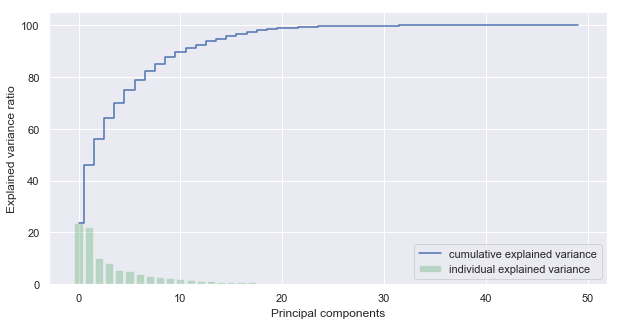

In [1683]:
# PLOT OUT THE EXPLAINED VARIANCES SUPERIMPOSED 
plt.figure(figsize=(10, 5))
plt.bar(range(len(pre90s_var_exp)), pre90s_var_exp, alpha=0.3333, align='center', label='individual explained variance', color = 'g')
plt.step(range(len(pre90s_cum_var_exp)), pre90s_cum_var_exp, where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show()

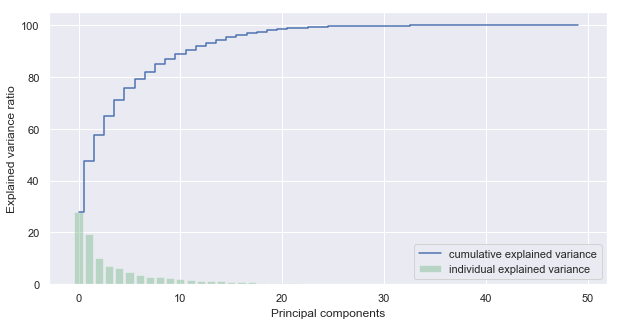

In [1684]:
plt.figure(figsize=(10, 5))
plt.bar(range(len(_10s_var_exp)), _10s_var_exp, alpha=0.3333, align='center', label='individual explained variance', color = 'g')
plt.step(range(len(_10s_cum_var_exp)), _10s_cum_var_exp, where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show()

With both visualization we can conclude that first six PC are needed to explain 75% of the variance while the seventh explains only 3.9%(pre90s) and 3.8%(_10s) of the variance. So, for both dataset we will select only the first six PCs.

In [1685]:
# Compute first 6 PCs by matrix multiplying the standardized data array 
# by the first 6 columns of the array of eigenvectors.
#print(x_z.shape)
#print(type(x_z))
#print(eigen_RR[1].shape)
#pre90s_PCs = np.dot(pre90s_z, eigen_RR[1][:, :6])
#print(type(PCs))
#print(PCs.shape)
#print(PCs[:5, ])

### Dimensionality reduction with PCA

By using PCA we will be able to reduce these 50 variables to just the 6 of them that best captures that information.

In order to do so, we will first perform PCA implementation that comes with Python's sklearn machine learning library and plot the first six PCs for both datasets.

In [1686]:
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
pca.fit(pre90s_z)

PCA(copy=True, iterated_power='auto', n_components=6, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

This gives us an object we can use to transform our data by calling transform.

In [1687]:
pre90s_existing_6d = pca.transform(pre90s_z)

We end up with a lower dimension representation of our data frame, as a numPy array. Let's put it in a new dataframe.

In [1688]:
pre90s_existing_df_6d = pd.DataFrame(pre90s_existing_6d)
pre90s_existing_df_6d.index = pre90s_z.index
pre90s_existing_df_6d.columns = ['PC1','PC2','PC3','PC4','PC5','PC6']
pre90s_existing_df_6d.head()

,PC1,PC2,PC3,PC4,PC5,PC6
0,7.273874,6.948453,0.978523,-2.550222,0.397758,2.387515
1,1.447831,0.728610,-0.818381,-1.885773,-2.900113,-0.577905
2,3.200364,1.918387,2.404086,-3.459734,1.652350,1.641400
3,-3.464682,0.190444,1.216523,-3.772571,-0.952150,0.264033
4,-4.684307,-1.843314,3.290766,-1.518109,-2.704522,-2.006349


In [1689]:
#print(pca.explained_variance_ratio_) 

Repeat the same steps for the post 2010 dataset.

In [1690]:
pca = PCA(n_components=6)
pca.fit(_10s_z)
_10s_existing_6d = pca.transform(_10s_z)
_10s_existing_df_6d = pd.DataFrame(_10s_existing_6d)
_10s_existing_df_6d.index = _10s_z.index
_10s_existing_df_6d.columns = ['PC1','PC2','PC3','PC4','PC5','PC6']
_10s_existing_df_6d.head()

,PC1,PC2,PC3,PC4,PC5,PC6
9290,-1.963759,-0.567111,-2.980483,-0.219455,-3.782857,-0.981024
9291,3.308441,2.273132,0.994559,-0.964905,-3.442588,-2.503814
9292,-1.345550,-7.256748,3.965585,-0.604112,-2.558684,0.497309
9293,-1.340843,3.024303,-2.507949,-0.392478,-3.885300,-0.570075
9294,2.328623,-0.516323,1.444947,5.487116,-1.100170,1.575889


With these two simplied dataset with reduced dimension of 6, we can explore the different choices of number for clustering. I will keep the options open from 2 to 20.

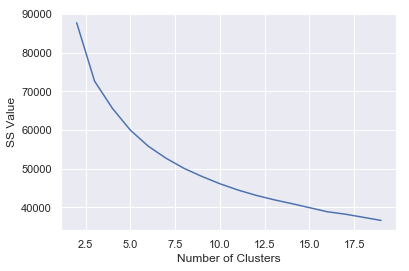

In [1691]:
from sklearn.cluster import KMeans

SS = []

for i in range(2,20):
    km = KMeans(n_clusters = i)
    km.fit(pre90s_existing_df_6d)
    SS.append(km.inertia_)
    
plt.plot(range(2,20), SS)
plt.xlabel('Number of Clusters')
plt.ylabel('SS Value')
plt.show()

By using the albew method, we can tell starting from 7, the SS value kind of stop decreasing as rapidly as before, so I will choose 7 as the number of clusters.

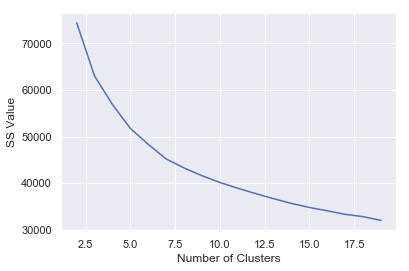

In [1692]:
SS = []

for i in range(2,20):
    km = KMeans(n_clusters = i)
    km.fit(_10s_existing_df_6d)
    SS.append(km.inertia_)
    
plt.plot(range(2,20), SS)
plt.xlabel('Number of Clusters')
plt.ylabel('SS Value')
plt.show()

For the 10s dataset, we can tell more clearly that starting from 7, the SS value stop decreasing so rapidly, so I will also choose 7 as the number of clusters.

In [1693]:
import scipy
from scipy.cluster.vq import vq, kmeans, whiten
from pylab import plot,show
from numpy import vstack,array
from numpy.random import rand
from scipy.cluster.vq import kmeans,vq

#changing x_z from dataframe to an array
pre90s_z1 = np.array(pre90s_existing_df_6d)

##kmeans clustering for 7 clusters
pre90s_kmeans_x,_ = kmeans(pre90s_z1,7)
#print(pre90s_kmeans_x)

In [1694]:
_10s_z1 = np.array(_10s_existing_df_6d)
_10s_kmeans_x,_ = kmeans(_10s_z1,7)
#print(_10s_kmeans_x)

To see, if the PCA algorithm will be able to separate the clusters, I am adding clusters from (k =7) to the original dataframe. Then I will plot the scatterplot of PC1 vs PC2, which are the two most prominent ones to see if the seven clusters separate as they should.

In [1695]:
pre90s_idx7,_ = vq(pre90s_z1,pre90s_kmeans_x)

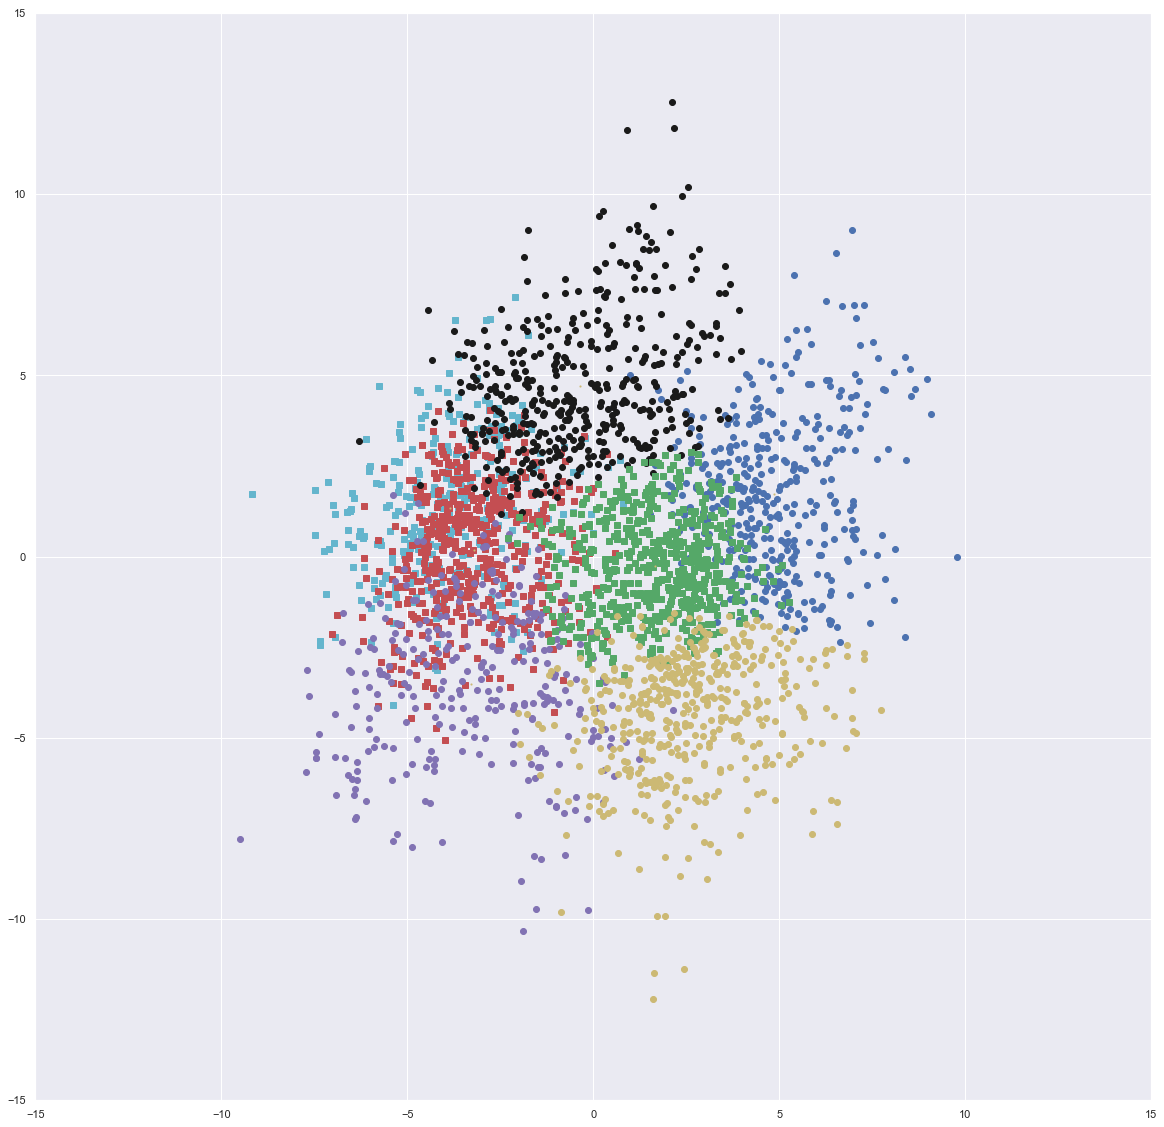

In [1696]:
plt.figure(figsize=(20,20))
plt.plot(pre90s_z1[pre90s_idx7==0,0],pre90s_z1[pre90s_idx7==0,1],'sc',
     pre90s_z1[pre90s_idx7==1,0],pre90s_z1[pre90s_idx7==1,1],'sr',
     pre90s_z1[pre90s_idx7==2,0],pre90s_z1[pre90s_idx7==2,1],'om',
     pre90s_z1[pre90s_idx7==3,0],pre90s_z1[pre90s_idx7==3,1],'ob',
     pre90s_z1[pre90s_idx7==4,0],pre90s_z1[pre90s_idx7==4,1],'ok',
     pre90s_z1[pre90s_idx7==5,0],pre90s_z1[pre90s_idx7==5,1],'sg',
     pre90s_z1[pre90s_idx7==6,0],pre90s_z1[pre90s_idx7==6,1],'oy')
plt.plot(pre90s_kmeans_x[:,0],pre90s_kmeans_x[:,1],'sy',markersize=1)
plt.xlim(-15.0, 15.0)
plt.ylim(-15.0, 15.0)
show()


The 7 clusters are very clear for the pre90s dataset.

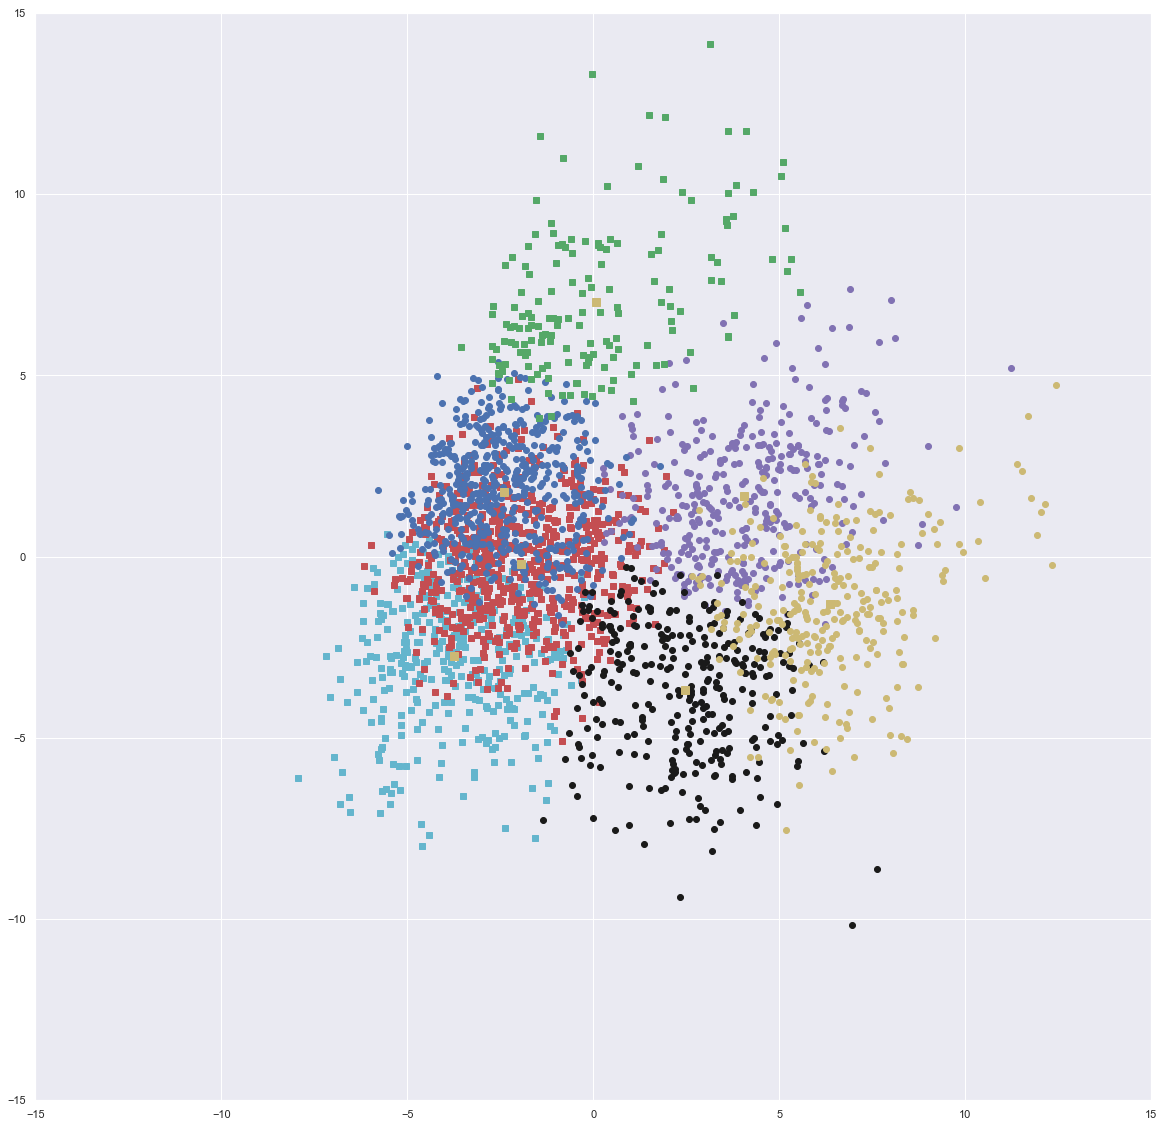

In [1697]:
_10s_idx7,_ = vq(_10s_z1,_10s_kmeans_x)
plt.figure(figsize=(20,20))
plt.plot(_10s_z1[_10s_idx7==0,0],_10s_z1[_10s_idx7==0,1],'sc',
     _10s_z1[_10s_idx7==1,0],_10s_z1[_10s_idx7==1,1],'sr',
     _10s_z1[_10s_idx7==2,0],_10s_z1[_10s_idx7==2,1],'om',
     _10s_z1[_10s_idx7==3,0],_10s_z1[_10s_idx7==3,1],'ob',
     _10s_z1[_10s_idx7==4,0],_10s_z1[_10s_idx7==4,1],'ok',
     _10s_z1[_10s_idx7==5,0],_10s_z1[_10s_idx7==5,1],'sg',
     _10s_z1[_10s_idx7==6,0],_10s_z1[_10s_idx7==6,1],'oy')
plt.plot(_10s_kmeans_x[:,0],_10s_kmeans_x[:,1],'sy',markersize=8)
plt.xlim(-15.0, 15.0)
plt.ylim(-15.0, 15.0)
show()

The 7 clusters are very distinguishable for the _10s dataset.

### Intepretation of clusters

#### For pre 1990 data

In [1698]:
pre90s_cluster = pre90s_idx7
type(pre90s_cluster)

numpy.ndarray

#### Intepraate through normalized dataset

Since in normalized dataset all the attributes are scaled to the same range, and the relative difference are also scaled to the same range, which makes it easy to have visual comparison.

<Figure size 432x288 with 0 Axes>

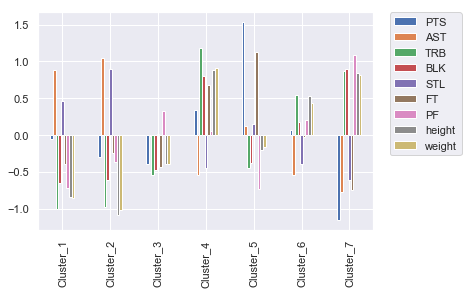

In [1699]:
##Add the cluster membership to first dataframe x
pre90s_z['cluster_ID'] = pre90s_cluster[:]
pre90s_z_cluster_sort = pre90s_z.sort_values('cluster_ID')

## Sort the players by cluster membership
cluster1 = pre90s_z_cluster_sort.loc[pre90s_z_cluster_sort["cluster_ID"] == 0]
cluster2 = pre90s_z_cluster_sort.loc[pre90s_z_cluster_sort["cluster_ID"] == 1]
cluster3 = pre90s_z_cluster_sort.loc[pre90s_z_cluster_sort["cluster_ID"] == 2]
cluster4 = pre90s_z_cluster_sort.loc[pre90s_z_cluster_sort["cluster_ID"] == 3]
cluster5 = pre90s_z_cluster_sort.loc[pre90s_z_cluster_sort["cluster_ID"] == 4]
cluster6 = pre90s_z_cluster_sort.loc[pre90s_z_cluster_sort["cluster_ID"] == 5]
cluster7 = pre90s_z_cluster_sort.loc[pre90s_z_cluster_sort["cluster_ID"] == 6]

#calculate mean values for each clusters
c1means = pd.DataFrame(cluster1.mean())
c2means = pd.DataFrame(cluster2.mean())
c3means = pd.DataFrame(cluster3.mean())
c4means = pd.DataFrame(cluster4.mean())
c5means = pd.DataFrame(cluster5.mean())
c6means = pd.DataFrame(cluster6.mean())
c7means = pd.DataFrame(cluster7.mean())

summary = pd.concat([c1means, c2means, c3means, c4means, c5means, c6means, c7means], axis=1, join_axes = [c1means.index])

## Assign column names to the dataframe summary
summary.columns = ['Cluster_1', 'Cluster_2', 'Cluster_3', 'Cluster_4', 'Cluster_5', 'Cluster_6', 'Cluster_7']

summary_feature = summary.loc[['PTS','AST','TRB','BLK','STL','FT','PF','height','weight']]
summary_feature = summary_feature.transpose()
plt.figure()
summary_feature.plot(kind ='bar')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) ## to move the legend outside of plot
plt.show()

#### Intepraate through unnormalized dataset

Unnormalized dataset helps to see the real facts of attributes of each cluster.

In [1700]:
pre90s_all['cluster_ID'] = pre90s_cluster[:]
pre90s_all_cluster_sort = pre90s_all.sort_values('cluster_ID')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [1701]:
cluster1 = pre90s_all_cluster_sort.loc[pre90s_all_cluster_sort["cluster_ID"] == 0]
cluster2 = pre90s_all_cluster_sort.loc[pre90s_all_cluster_sort["cluster_ID"] == 1]
cluster3 = pre90s_all_cluster_sort.loc[pre90s_all_cluster_sort["cluster_ID"] == 2]
cluster4 = pre90s_all_cluster_sort.loc[pre90s_all_cluster_sort["cluster_ID"] == 3]
cluster5 = pre90s_all_cluster_sort.loc[pre90s_all_cluster_sort["cluster_ID"] == 4]
cluster6 = pre90s_all_cluster_sort.loc[pre90s_all_cluster_sort["cluster_ID"] == 5]
cluster7 = pre90s_all_cluster_sort.loc[pre90s_all_cluster_sort["cluster_ID"] == 6]

Now, lets look at the characteristics of each cluster by calculating means of each clusters.

In [1702]:
#calculate mean values for each clusters
c1means = pd.DataFrame(cluster1.mean())
c2means = pd.DataFrame(cluster2.mean())
c3means = pd.DataFrame(cluster3.mean())
c4means = pd.DataFrame(cluster4.mean())
c5means = pd.DataFrame(cluster5.mean())
c6means = pd.DataFrame(cluster6.mean())
c7means = pd.DataFrame(cluster7.mean())

In [1703]:
##Concatenate the seven dataframes along axis =1 using the index from c1means
summary = pd.concat([c1means, c2means, c3means, c4means, c5means, c6means, c7means], axis=1, join_axes = [c1means.index])

## Assign column names to the dataframe summary
summary.columns = ['Cluster_1', 'Cluster_2', 'Cluster_3', 'Cluster_4', 'Cluster_5', 'Cluster_6', 'Cluster_7']
print(summary)

                Cluster_1    Cluster_2    Cluster_3    Cluster_4    Cluster_5  \
Unnamed: 0    5571.145455  4298.174721  4775.894389  4855.263547  4730.045872   
Unnamed: 0.1  8419.818182  6568.592937  7262.455446  7374.881773  7193.337156   
Year          1986.754545  1981.776952  1983.607261  1983.923645  1983.472477   
Age             27.230303    25.996283    25.399340    26.470443    26.477064   
G               72.533333    73.384758    56.676568    76.559113    75.832569   
MP            1866.193939  1828.401487   780.709571  2256.209360  2432.717890   
PER              0.307606     0.290500     0.516540     0.296357     0.295412   
TS%              0.530645     0.512028     0.467937     0.584938     0.550913   
3PAr             0.153185     0.028745     0.035201     0.006155     0.027725   
FTr              0.248652     0.294743     0.268729     0.457978     0.324011   
ORB%             3.114848     3.405019     5.288779    10.173399     5.668807   
DRB%             7.796667   

We can also understand the character of each cluster by selecting prominent players in each cluster. Here I use minutes played(MP) as the criteria for elite players, since usually the elite players are given more opportunites to carry the game. 

In [1704]:
cluster1.loc[cluster1['MP'] >= 3100]

,Unnamed: 0,Unnamed: 0.1,Year,Player,Pos,Age,Tm,G,MP,PER,...,TRB,AST,STL,BLK,TOV,PF,PTS,height,weight,cluster_ID
2060,5284,7974,1986,Maurice Cheeks,PG,29,PHI,82,3270.0,0.197064,...,2.587156,8.289908,2.278899,0.297248,2.620183,1.761468,13.937615,185.0,81.0,0
2646,5873,8852,1988,Mark Jackson,PG,22,NYK,82,3249.0,0.173961,...,4.387812,9.617729,2.271468,0.066482,2.858726,2.703601,12.343490,185.0,81.0,0
2984,6213,9401,1989,Terry Porter,PG,25,POR,81,3102.0,0.205416,...,4.259188,8.936170,1.694391,0.092843,2.878143,2.170213,16.607350,190.0,88.0,0
3024,6253,9461,1989,John Stockton,PG,26,UTA,82,3171.0,0.259981,...,2.815516,12.692526,2.985809,0.158940,3.496689,2.736045,15.894040,185.0,77.0,0
3018,6247,9452,1989,Kenny Smith,PG,23,SAC,81,3145.0,0.163688,...,2.586963,7.108426,1.167568,0.080127,2.850238,1.980286,16.059777,190.0,77.0,0
2867,6096,9213,1989,Dale Ellis,SG,28,SEA,82,3190.0,0.222320,...,3.859561,1.850784,1.218809,0.248276,2.460188,2.223197,25.425705,201.0,92.0,0


In [1705]:
cluster2.loc[cluster2['MP'] >= 3100]

,Unnamed: 0,Unnamed: 0.1,Year,Player,Pos,Age,Tm,G,MP,PER,...,TRB,AST,STL,BLK,TOV,PF,PTS,height,weight,cluster_ID
665,3886,5978,1980,Norm Nixon,PG,24,LAL,82,3226.0,0.166274,...,2.555487,7.164290,1.640422,0.156231,3.213887,2.689399,16.136392,188.0,77.0,1
933,4156,6364,1981,Micheal Ray,SG,25,NYK,79,3175.0,0.193890,...,6.179528,7.109291,2.630551,0.396850,3.424252,2.925354,14.660787,198.0,85.0,1
452,3671,5669,1979,Randy Smith,SG,30,SDC,82,3111.0,0.192093,...,3.413693,4.570878,2.048216,0.057859,2.950820,2.048216,19.417551,190.0,81.0,1
412,3631,5610,1979,Norm Nixon,PG,23,LAL,82,3145.0,0.208331,...,2.644197,8.436248,2.300795,0.194595,2.644197,2.861685,16.071224,188.0,77.0,1
289,3507,5437,1979,M.L. Carr,SF,28,DET,80,3207.0,0.182975,...,6.611787,2.941066,2.211413,0.516370,2.862488,3.131899,16.804490,183.0,74.0,1


Since we also want to explore the relationship between the traditional way of clustering players which is according to the position, with our new method, I will also use bar plot to observe the distribution of player position within each cluster.

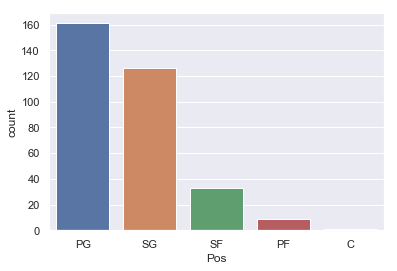

In [1706]:
import seaborn as sns
sns.set(style="darkgrid")
ax = sns.countplot(x="Pos", data=cluster1, order=["PG", "SG", "SF","PF","C"])

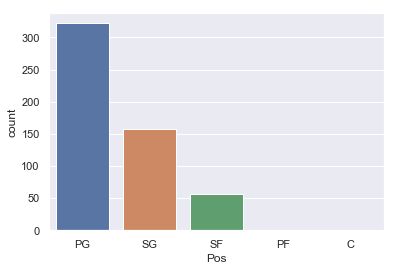

In [1707]:
ax = sns.countplot(x="Pos", data=cluster2,order=["PG", "SG", "SF","PF","C"])

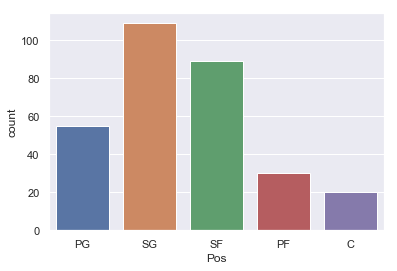

In [1708]:
ax = sns.countplot(x="Pos", data=cluster3,order=["PG", "SG", "SF","PF","C"])

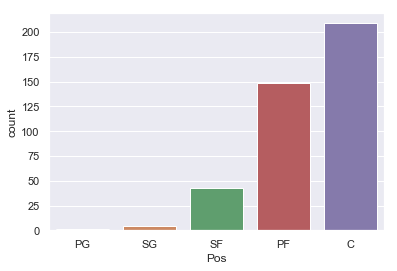

In [1709]:
ax = sns.countplot(x="Pos", data=cluster4,order=["PG", "SG", "SF","PF","C"])

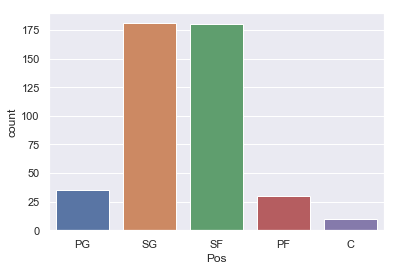

In [1710]:
ax = sns.countplot(x="Pos", data=cluster5,order=["PG", "SG", "SF","PF","C"])

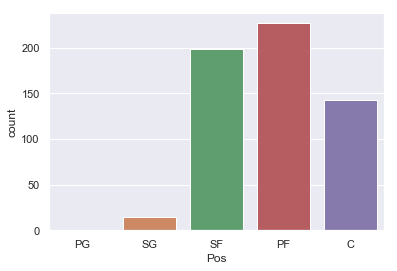

In [1711]:
ax = sns.countplot(x="Pos", data=cluster6,order=["PG", "SG", "SF","PF","C"])

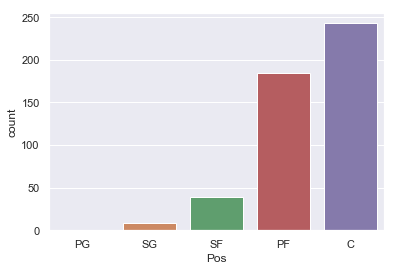

In [1712]:
ax = sns.countplot(x="Pos", data=cluster7,order=["PG", "SG", "SF","PF","C"])

#### Repeat similar approach for post 2010 data

In [1744]:
_10s_cluster = _10s_idx7
_10s_all['cluster_ID'] = _10s_cluster[:]
_10s_all_cluster_sort = _10s_all.sort_values('cluster_ID')

cluster1 = _10s_all_cluster_sort.loc[_10s_all_cluster_sort["cluster_ID"] == 0]
cluster2 = _10s_all_cluster_sort.loc[_10s_all_cluster_sort["cluster_ID"] == 1]
cluster3 = _10s_all_cluster_sort.loc[_10s_all_cluster_sort["cluster_ID"] == 2]
cluster4 = _10s_all_cluster_sort.loc[_10s_all_cluster_sort["cluster_ID"] == 3]
cluster5 = _10s_all_cluster_sort.loc[_10s_all_cluster_sort["cluster_ID"] == 4]
cluster6 = _10s_all_cluster_sort.loc[_10s_all_cluster_sort["cluster_ID"] == 5]
cluster7 = _10s_all_cluster_sort.loc[_10s_all_cluster_sort["cluster_ID"] == 6]

#calculate mean values for each clusters
c1means = pd.DataFrame(cluster1.mean())
c2means = pd.DataFrame(cluster2.mean())
c3means = pd.DataFrame(cluster3.mean())
c4means = pd.DataFrame(cluster4.mean())
c5means = pd.DataFrame(cluster5.mean())
c6means = pd.DataFrame(cluster6.mean())
c7means = pd.DataFrame(cluster7.mean())

##Concatenate the three dataframes along axis =1 using the index from c1means
summary = pd.concat([c1means, c2means, c3means, c4means, c5means, c6means, c7means], axis=1, join_axes = [c1means.index])

## Assign column names to the dataframe summary
summary.columns = ['Cluster_1', 'Cluster_2', 'Cluster_3', 'Cluster_4', 'Cluster_5', 'Cluster_6', 'Cluster_7']
print(summary)

                 Cluster_1     Cluster_2     Cluster_3     Cluster_4  \
Unnamed: 0    14152.032995  14175.476261  13997.157303  13723.792350   
Unnamed: 0.1  22601.220812  22641.862018  22334.676966  21866.719490   
Year           2014.005076   2014.114243   2013.567416   2012.805100   
Age              26.362944     27.488131     26.584270     26.120219   
G                56.842640     68.925816     70.839888     67.626594   
MP             1013.073604   1692.875371   2046.120787   1892.836066   
PER               0.388349      0.302681      0.350848      0.313441   
TS%               0.480086      0.550703      0.547447      0.527572   
3PAr              0.370452      0.467408      0.077430      0.280337   
FTr               0.196500      0.197411      0.316334      0.270270   
ORB%              2.617513      3.213798      8.575281      2.520947   
DRB%             10.901269     12.659941     21.365169     10.451913   
TRB%              6.738579      7.952819     14.967697      6.46

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [1748]:
cluster1.loc[cluster1['MP'] >= 1900]

,Unnamed: 0,Unnamed: 0.1,Year,Player,Pos,Age,Tm,G,MP,PER,...,TRB,AST,STL,BLK,TOV,PF,PTS,height,weight,cluster_ID
11164,14502,23203,2015,Zach LaVine,PG,19,MIN,77,1902.0,0.213880,...,4.050473,5.223975,1.022082,0.189274,3.652997,2.990536,14.725552,196.0,85.0,0
11185,14523,23235,2015,Luc Mbah,PF,28,PHI,67,1916.0,0.199165,...,6.162839,1.991649,1.521921,0.394572,1.860125,1.954071,12.400835,201.0,99.0,0
9881,13201,20936,2011,Travis Outlaw,SF,26,NJN,82,2358.0,0.134351,...,4.961832,1.282443,0.519084,0.549618,1.083969,2.259542,11.541985,206.0,95.0,0
11500,14842,23796,2016,Joe Johnson,SF,34,BRK,57,1934.0,0.199173,...,4.169597,4.318511,0.744571,0.037229,2.159255,1.861427,12.490176,201.0,90.0,0
11248,14588,23370,2015,Rajon Rondo,PG,28,TOT,68,2018.0,0.240833,...,6.654113,9.597621,1.623389,0.124876,3.746283,2.729435,10.846383,185.0,84.0,0
10836,14169,22631,2014,Ben McLemore,SG,20,SAC,82,2187.0,0.126749,...,3.868313,1.349794,0.740741,0.296296,1.580247,3.308642,11.851852,196.0,88.0,0
10880,14213,22712,2014,Tayshaun Prince,SF,33,MEM,76,1948.0,0.151540,...,4.324435,2.199179,0.720739,0.351129,0.757700,1.164271,8.390144,206.0,96.0,0
10689,14021,22381,2014,Norris Cole,PG,25,MIA,82,2014.0,0.157299,...,2.859980,4.432969,1.376365,0.089374,2.270109,2.788481,9.420060,188.0,79.0,0
9379,12684,20068,2010,Chris Duhon,PG,27,NYK,67,2072.0,0.185907,...,3.092664,6.567568,1.025097,0.052124,1.911197,1.442085,8.583012,185.0,83.0,0
11761,15104,24224,2017,Matthew Dellavedova,PG,26,MIL,76,1986.0,0.170393,...,2.664653,6.471299,0.960725,0.000000,2.410876,2.773414,10.459215,193.0,89.0,0


In [1749]:
cluster2.loc[cluster2['MP'] >= 1800]

,Unnamed: 0,Unnamed: 0.1,Year,Player,Pos,Age,Tm,G,MP,PER,...,TRB,AST,STL,BLK,TOV,PF,PTS,height,weight,cluster_ID
11881,15225,24411,2017,Courtney Lee,SG,31,NYK,77,2459.0,0.177145,...,3.806425,2.620577,1.185848,0.336722,1.010167,2.064254,12.224481,196.0,90.0,1
10646,13978,22302,2014,Nicolas Batum,SF,25,POR,82,2956.0,0.192422,...,7.441137,5.115020,0.913396,0.694181,2.533153,1.899865,13.031123,203.0,90.0,1
10680,14012,22367,2014,DeMarre Carroll,SF,27,ATL,73,2341.0,0.213755,...,6.197352,2.060658,1.660829,0.322939,1.214865,2.891072,12.456215,203.0,97.0,1
10653,13985,22312,2014,Marco Belinelli,SF,27,SAS,80,2016.0,0.267857,...,4.035714,3.196429,0.892857,0.125000,1.696429,2.321429,16.267857,196.0,95.0,1
10686,14018,22373,2014,Wilson Chandler,SF,26,DEN,62,1927.0,0.231655,...,5.492475,2.129735,0.859367,0.579139,1.475869,3.605605,15.804878,203.0,102.0,1
10642,13974,22297,2014,Harrison Barnes,SF,21,GSW,78,2204.0,0.160073,...,5.079855,1.894737,1.061706,0.326679,1.372051,2.580762,12.054446,190.0,92.0,1
10668,14000,22333,2014,Corey Brewer,SF,27,MIN,81,2609.0,0.175240,...,2.856267,1.862783,2.083557,0.413952,1.448831,2.897662,13.770793,206.0,84.0,1
10630,13962,22275,2014,James Anderson,SG,24,PHI,80,2309.0,0.169944,...,4.677350,2.323084,1.153746,0.436553,1.652663,2.401039,12.628844,198.0,96.0,1
10625,13957,22267,2014,Ray Allen,SG,38,MIA,73,1936.0,0.238017,...,3.811983,2.659091,1.004132,0.148760,1.561983,2.138430,13.035124,203.0,99.0,1
11869,15212,24391,2017,Frank Kaminsky,C,23,CHO,75,1954.0,0.239509,...,6.190379,2.984647,0.865916,0.626407,1.400205,2.560901,16.102354,213.0,109.0,1


In [1716]:
cluster3.loc[cluster3['MP'] >= 2800]

,Unnamed: 0,Unnamed: 0.1,Year,Player,Pos,Age,Tm,G,MP,PER,...,TRB,AST,STL,BLK,TOV,PF,PTS,height,weight,cluster_ID
9814,13133,20817,2011,Al Jefferson,C,26,UTA,82,2940.0,0.246122,...,9.722449,1.824490,0.563265,1.873469,1.285714,2.914286,18.710204,208.0,131.0,2
9802,13120,20795,2011,Dwight Howard,C,25,ORL,78,2935.0,0.320136,...,13.467802,1.312436,1.312436,2.281431,3.422147,3.164566,21.882112,211.0,120.0,2
9839,13159,20870,2011,Brook Lopez,C,22,NJN,82,2889.0,0.240498,...,6.080997,1.607477,0.585670,1.495327,2.193146,2.990654,20.847352,213.0,124.0,2
10756,14088,22494,2014,Blake Griffin,PF,24,LAC,80,2863.0,0.300524,...,9.518687,3.885435,1.156829,0.641285,2.816626,3.332169,24.268250,208.0,113.0,2
12003,15347,24625,2017,Karl-Anthony Towns,C,21,MIN,82,3030.0,0.308911,...,11.964356,2.613861,0.677228,1.223762,2.518812,2.863366,24.487129,213.0,110.0,2
9291,12594,19924,2010,LaMarcus Aldridge,PF,24,POR,78,2922.0,0.224230,...,7.724846,1.971253,0.825462,0.591376,1.281314,2.845996,17.162218,211.0,117.0,2
10859,14192,22675,2014,Joakim Noah,C,28,CHI,80,2820.0,0.255319,...,11.489362,5.502128,1.263830,1.544681,2.476596,3.127660,12.855319,211.0,104.0,2
9923,13244,21027,2011,Amar'e Stoudemire,C,28,NYK,78,2870.0,0.284739,...,7.977700,2.533798,0.890592,1.881533,3.135889,3.436934,24.723345,208.0,111.0,2
9591,12903,20463,2010,Gerald Wallace,SF,27,CHA,76,3119.0,0.211222,...,8.795127,1.858288,1.350433,0.957999,2.054505,2.239179,15.997435,201.0,97.0,2
9599,12911,20474,2010,David West,PF,29,NOH,81,2949.0,0.230722,...,7.385554,2.917599,0.927772,0.732452,2.111902,2.844354,18.811801,206.0,113.0,2


In [1717]:
cluster4.loc[cluster4['MP'] >= 2900]

,Unnamed: 0,Unnamed: 0.1,Year,Player,Pos,Age,Tm,G,MP,PER,...,TRB,AST,STL,BLK,TOV,PF,PTS,height,weight,cluster_ID
9798,13116,20791,2011,Jrue Holiday,PG,20,PHI,82,2901.0,0.191107,...,4.119959,6.589452,1.489142,0.359876,2.705274,2.519131,14.208893,193.0,92.0,3
10423,13751,21914,2013,Jrue Holiday,PG,22,PHI,78,2926.0,0.205468,...,4.047847,7.689679,1.513329,0.393712,3.592618,2.091593,17.015721,193.0,92.0,3
10487,13817,22023,2013,O.J. Mayo,SG,25,DAL,82,2913.0,0.171782,...,3.596292,4.461380,1.149331,0.284243,2.595263,2.409887,15.509784,201.0,99.0,3
10391,13718,21862,2013,Paul George,SF,22,IND,79,2972.0,0.203499,...,7.304172,3.960969,1.732167,0.617766,2.822342,2.749664,16.679677,206.0,99.0,3
9732,13045,20687,2011,Monta Ellis,SG,25,GSW,80,3227.0,0.207499,...,3.134800,5.020143,1.874187,0.256585,2.811280,2.264642,21.519678,190.0,83.0,3
10471,13800,21995,2013,Damian Lillard,PG,22,POR,82,3167.0,0.186422,...,2.921377,6.035996,0.841175,0.215977,2.762236,1.955163,17.755605,190.0,88.0,3
9717,13030,20666,2011,Luol Deng,SF,25,CHI,82,3208.0,0.173940,...,5.341646,2.581047,0.875312,0.538653,1.750623,1.817955,16.047382,206.0,99.0,3
11312,14653,23483,2015,Andrew Wiggins,SF,19,MIN,82,2969.0,0.168542,...,4.534860,2.061300,1.042775,0.606265,2.146177,2.303806,16.817784,203.0,90.0,3
9414,12720,20124,2010,Jeff Green,PF,23,OKC,82,3043.0,0.163260,...,5.796911,1.585278,1.230365,0.851791,1.597108,2.614525,14.657903,196.0,88.0,3
9401,12706,20100,2010,Rudy Gay,SF,23,MEM,80,3175.0,0.183685,...,5.351811,1.734803,1.337953,0.725669,1.916220,2.279055,17.767559,203.0,104.0,3


In [1753]:
cluster5.loc[cluster5['MP'] >= 1800]

,Unnamed: 0,Unnamed: 0.1,Year,Player,Pos,Age,Tm,G,MP,PER,...,TRB,AST,STL,BLK,TOV,PF,PTS,height,weight,cluster_ID
11469,14811,23740,2016,Roy Hibbert,C,29,LAL,81,1878.0,0.214696,...,7.629393,1.821086,0.613419,2.108626,1.456869,4.830671,9.220447,218.0,122.0,4
10920,14254,22796,2014,Jason Thompson,PF,27,SAC,82,2007.0,0.199103,...,9.452915,0.950673,0.573991,1.004484,1.704036,4.502242,10.511211,185.0,83.0,4
10277,13602,21690,2013,Al-Farouq Aminu,SF,22,NOH,76,2066.0,0.238722,...,10.193611,1.794773,1.603098,0.888674,2.021297,2.666021,9.670862,206.0,99.0,4
11447,14789,23702,2016,Jerami Grant,SF,21,PHI,77,2066.0,0.219555,...,6.290416,2.352372,0.940949,2.212972,1.916747,3.746370,13.051307,203.0,95.0,4
10397,13724,21869,2013,Marcin Gortat,C,28,PHO,61,1876.0,0.295522,...,9.901919,1.439232,0.767591,1.880597,1.899787,2.437100,13.049041,211.0,108.0,4
10408,13735,21887,2013,Maurice Harkless,SF,19,ORL,76,1974.0,0.227964,...,6.109422,0.911854,1.604863,1.130699,1.258359,2.626140,11.398176,206.0,97.0,4
9423,12729,20144,2010,Spencer Hawes,C,21,SAC,72,1904.0,0.260924,...,8.243697,2.987395,0.605042,1.569328,2.476891,3.781513,13.670168,216.0,111.0,4
10276,13601,21689,2013,Tony Allen,SG,31,MEM,79,2109.0,0.225320,...,6.196302,1.672831,2.031294,0.751067,1.604552,3.601707,12.034139,193.0,96.0,4
10350,13675,21795,2013,Dante Cunningham,PF,25,MIN,80,2010.0,0.238209,...,7.307463,1.200000,1.504478,0.680597,1.002985,2.740299,12.447761,203.0,104.0,4
9493,12802,20284,2010,Luc Mbah,PF,23,MIL,73,1866.0,0.227653,...,7.717042,1.562701,1.157556,0.752412,1.350482,3.491961,8.739550,201.0,99.0,4


In [1719]:
cluster6.loc[cluster6['MP'] >= 2000]

,Unnamed: 0,Unnamed: 0.1,Year,Player,Pos,Age,Tm,G,MP,PER,...,TRB,AST,STL,BLK,TOV,PF,PTS,height,weight,cluster_ID
9300,12603,19937,2010,Carmelo Anthony,SF,25,DEN,69,2634.0,0.303417,...,6.205011,3.034169,1.202733,0.410023,2.856492,3.075171,26.555809,203.0,108.0,5
10788,14120,22548,2014,LeBron James,PF,29,MIA,77,2902.0,0.363473,...,6.611992,6.053756,1.501034,0.322536,3.349414,1.563060,25.914542,203.0,113.0,5
11812,15155,24306,2017,James Harden,PG,27,HOU,81,2947.0,0.333492,...,8.050221,11.067526,1.465898,0.451985,5.668137,2.626400,28.780455,196.0,99.0,5
11821,15164,24321,2017,Gordon Hayward,SF,26,UTA,73,2516.0,0.317647,...,5.623211,3.605723,1.044515,0.286169,2.003180,1.674086,22.907790,203.0,102.0,5
11849,15192,24360,2017,Kyrie Irving,PG,24,CLE,72,2525.0,0.327921,...,3.279208,5.959604,1.183366,0.356436,2.566337,2.238416,25.891485,190.0,87.0,5
11662,15004,24060,2016,John Wall,PG,25,WAS,77,2784.0,0.256034,...,4.900862,10.202586,1.875000,0.762931,4.112069,2.056034,19.797414,193.0,88.0,5
10743,14075,22473,2014,Paul George,SF,23,IND,80,2898.0,0.249689,...,6.732919,3.515528,1.875776,0.273292,2.782609,2.459627,21.577640,206.0,99.0,5
10190,13515,21525,2012,Paul Pierce,SF,34,BOS,61,2075.0,0.340048,...,5.499759,4.753735,1.214458,0.451084,3.001446,2.550361,20.489639,201.0,106.0,5
11809,15152,24302,2017,Blake Griffin,PF,27,LAC,61,2076.0,0.393642,...,8.601156,5.202312,1.005780,0.398844,2.462428,2.722543,22.820809,208.0,113.0,5
11661,15003,24059,2016,Kemba Walker,PG,25,CHO,81,2885.0,0.259549,...,4.454766,5.253380,1.572270,0.486655,2.133795,1.385095,21.075910,203.0,95.0,5


In [1720]:
cluster7.loc[cluster7['MP'] >= 2200]

,Unnamed: 0,Unnamed: 0.1,Year,Player,Pos,Age,Tm,G,MP,PER,...,TRB,AST,STL,BLK,TOV,PF,PTS,height,weight,cluster_ID
9869,13189,20907,2011,Greg Monroe,C,20,DET,80,2222.0,0.291629,...,9.737174,1.701170,1.506751,0.729073,1.312331,3.175518,12.167417,211.0,120.0,6
10445,13774,21945,2013,Amir Johnson,PF,25,TOR,81,2325.0,0.267871,...,9.460645,1.889032,1.254194,1.703226,1.811613,4.660645,12.588387,206.0,108.0,6
11151,14488,23180,2015,DeAndre Jordan,C,26,LAC,82,2820.0,0.268085,...,15.651064,0.778723,1.034043,2.336170,1.391489,3.127660,12.076596,211.0,120.0,6
12001,15345,24618,2017,Tristan Thompson,C,25,CLE,78,2336.0,0.235788,...,11.034247,1.186644,0.601027,1.294521,0.986301,2.712329,9.708904,206.0,107.0,6
11057,14394,23036,2015,Andre Drummond,C,21,DET,82,2502.0,0.307914,...,15.884892,0.791367,1.050360,2.201439,1.726619,4.100719,16.258993,211.0,126.0,6
9805,13123,20800,2011,Serge Ibaka,PF,21,OKC,82,2216.0,0.287545,...,10.104693,0.357401,0.503610,3.216606,1.153430,4.337545,13.126354,208.0,106.0,6
9793,13110,20784,2011,Nene Hilario,C,28,DEN,75,2291.0,0.320559,...,8.972501,2.341336,1.319948,1.147097,2.105631,3.739852,17.143605,211.0,113.0,6
10512,13843,22065,2013,Joakim Noah,C,27,CHI,66,2426.0,0.268590,...,10.877164,3.887881,1.157461,2.092333,2.611707,2.745260,11.633965,211.0,104.0,6
11029,14365,22971,2015,Tyson Chandler,C,32,DAL,75,2286.0,0.316535,...,13.606299,1.322835,0.661417,1.433071,1.653543,2.661417,12.141732,216.0,108.0,6
11530,14872,23847,2016,Robin Lopez,C,27,NYK,82,2219.0,0.285534,...,9.766562,1.849482,0.259576,2.092835,2.157729,2.952681,13.660207,213.0,115.0,6


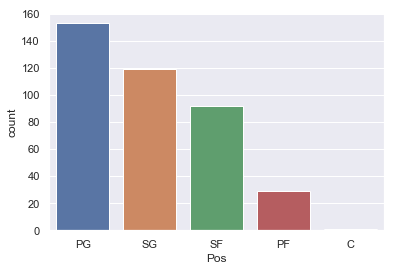

In [1721]:
ax = sns.countplot(x="Pos", data=cluster1, order=["PG", "SG", "SF","PF","C"])

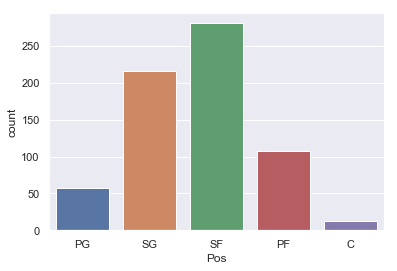

In [1722]:
ax = sns.countplot(x="Pos", data=cluster2, order=["PG", "SG", "SF","PF","C"])

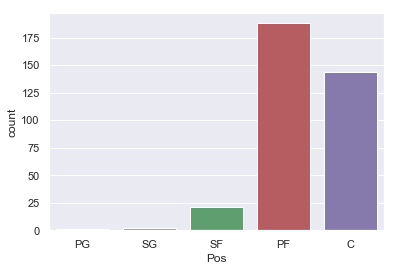

In [1723]:
ax = sns.countplot(x="Pos", data=cluster3, order=["PG", "SG", "SF","PF","C"])

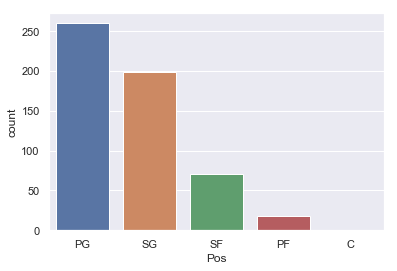

In [1724]:
ax = sns.countplot(x="Pos", data=cluster4, order=["PG", "SG", "SF","PF","C"])

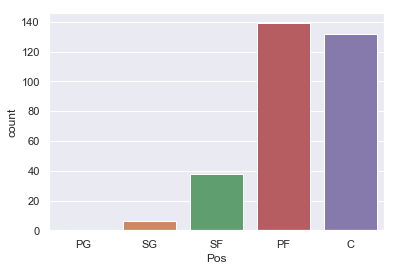

In [1725]:
ax = sns.countplot(x="Pos", data=cluster5, order=["PG", "SG", "SF","PF","C"])

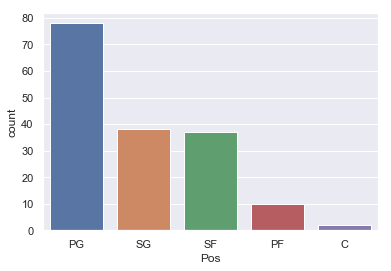

In [1726]:
ax = sns.countplot(x="Pos", data=cluster6, order=["PG", "SG", "SF","PF","C"])

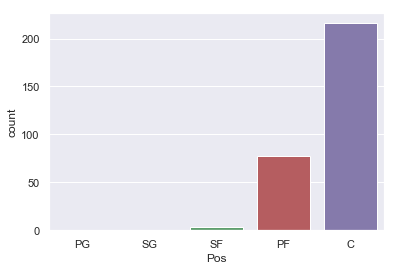

In [1727]:
ax = sns.countplot(x="Pos", data=cluster7, order=["PG", "SG", "SF","PF","C"])

In [1728]:
_10s_z['cluster_ID'] = _10s_cluster[:]
_10s_z_cluster_sort = _10s_z.sort_values('cluster_ID')

In [1729]:
cluster1 = _10s_z_cluster_sort.loc[_10s_z_cluster_sort["cluster_ID"] == 0]
cluster2 = _10s_z_cluster_sort.loc[_10s_z_cluster_sort["cluster_ID"] == 1]
cluster3 = _10s_z_cluster_sort.loc[_10s_z_cluster_sort["cluster_ID"] == 2]
cluster4 = _10s_z_cluster_sort.loc[_10s_z_cluster_sort["cluster_ID"] == 3]
cluster5 = _10s_z_cluster_sort.loc[_10s_z_cluster_sort["cluster_ID"] == 4]
cluster6 = _10s_z_cluster_sort.loc[_10s_z_cluster_sort["cluster_ID"] == 5]
cluster7 = _10s_z_cluster_sort.loc[_10s_z_cluster_sort["cluster_ID"] == 6]

In [1730]:
c1means = pd.DataFrame(cluster1.mean())
c2means = pd.DataFrame(cluster2.mean())
c3means = pd.DataFrame(cluster3.mean())
c4means = pd.DataFrame(cluster4.mean())
c5means = pd.DataFrame(cluster5.mean())
c6means = pd.DataFrame(cluster6.mean())
c7means = pd.DataFrame(cluster7.mean())

<Figure size 432x288 with 0 Axes>

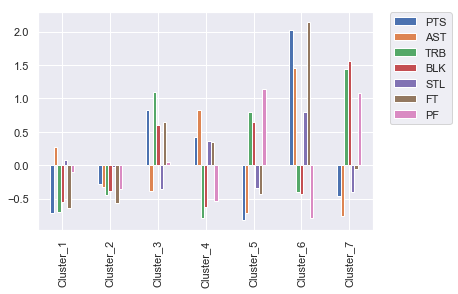

In [1731]:
summary = pd.concat([c1means, c2means, c3means, c4means, c5means, c6means, c7means], axis=1, join_axes = [c1means.index])

## Assign column names to the dataframe summary
summary.columns = ['Cluster_1', 'Cluster_2', 'Cluster_3', 'Cluster_4', 'Cluster_5', 'Cluster_6', 'Cluster_7']

summary_feature = summary.loc[['PTS','AST','TRB','BLK','STL','FT','PF']]
summary_feature = summary_feature.transpose()
plt.figure()
summary_feature.plot(kind ='bar')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) ## to move the legend outside of plot
plt.show()